## Project description: 

Inferring the causal impact of an event: Building a tool to determine the additional sales, application downloads, clicks, or website visits caused by a marketing campaign, the ROI of a marketing campaign, the effect of a promotion on demand, and any change in a time series caused by a known event. (Adapted from https://www.udemy.com/course/data-science-hacks-google-casual-impact/learn/lecture/22113296#overview)

In [ ]:
!pip install pycausalimpact

In [3]:
import numpy as np
import pandas as pd
import scipy
import statsmodels
import matplotlib.pyplot as plt
%matplotlib inline
import jinja2
from causalimpact import CausalImpact

# Building the Causal Impact Model (1)

In [4]:
# Time Index
ti = pd.date_range(start='2020-01-01', end='2020-07-31')

In [5]:
# Linear Function that determinates the relationship between y and X variables
def response_linearfunc(x, a, b):
    return a*x + b

In [6]:
# Predictor Variable X - Use a random variable, normally distributed
xdata = np.random.randn(len(ti)) + 5

# Response Variable y - Linear Combination of X + random noise
y_raw = response_linearfunc(xdata, 2, 1)
y_noise = (0.1 * np.random.normal(size=xdata.size) * y_raw)
ydata = y_raw + y_noise

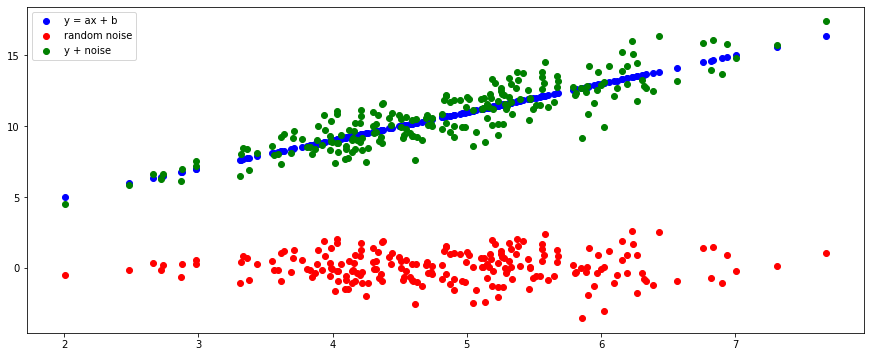

In [7]:
# Plots

plt.figure(figsize=(15,6))

plt.scatter(xdata, y_raw, c='blue')
plt.scatter(xdata, y_noise, c='red')
plt.scatter(xdata, ydata, c='green')

plt.legend(['y = ax + b', 'random noise', 'y + noise'])

plt.show()

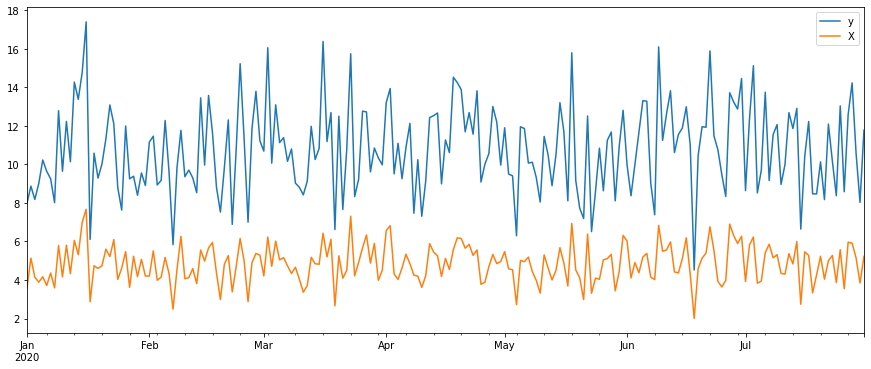

In [8]:
# Creating the dataframe
df = pd.DataFrame(data={'y': ydata, 
                        'X': xdata}, 
                  index=ti)

df.head()

# Plotting the Series
df.plot(figsize=(15,6));

In [9]:
# Last 30 Days of the Result DataFrame
df.loc['2020-07-01':]

,y,X
2020-07-01,8.645240,3.919827
2020-07-02,12.330398,5.811657
2020-07-03,15.127733,6.236188
2020-07-04,8.522008,3.834356
2020-07-05,9.700156,3.944038
2020-07-06,13.750766,5.417663
2020-07-07,9.168270,5.859772
2020-07-08,11.555448,5.151705
2020-07-09,12.069643,5.313946
2020-07-10,8.962212,4.343200


In [10]:
# Introducing Incremental Effect at last 30 days by 5 units
df['y'].loc['2020-07-01':] = df['y'].loc['2020-07-01':] + 5

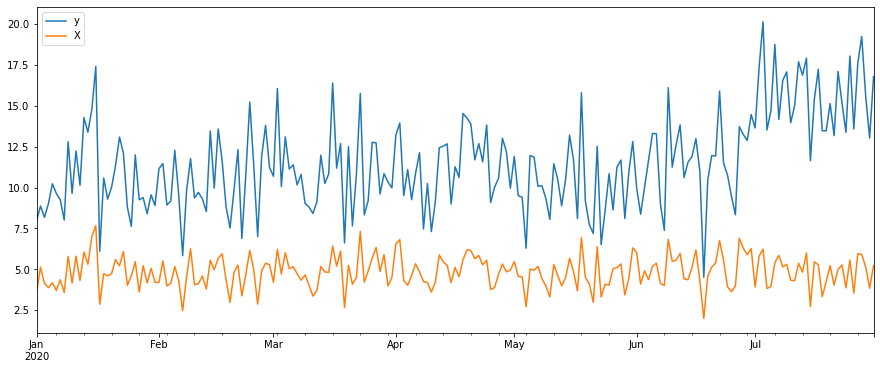

In [11]:
# Checking the Result of Incremental Effect
df.plot(figsize=(15,6));

# Causal Impact Analysis

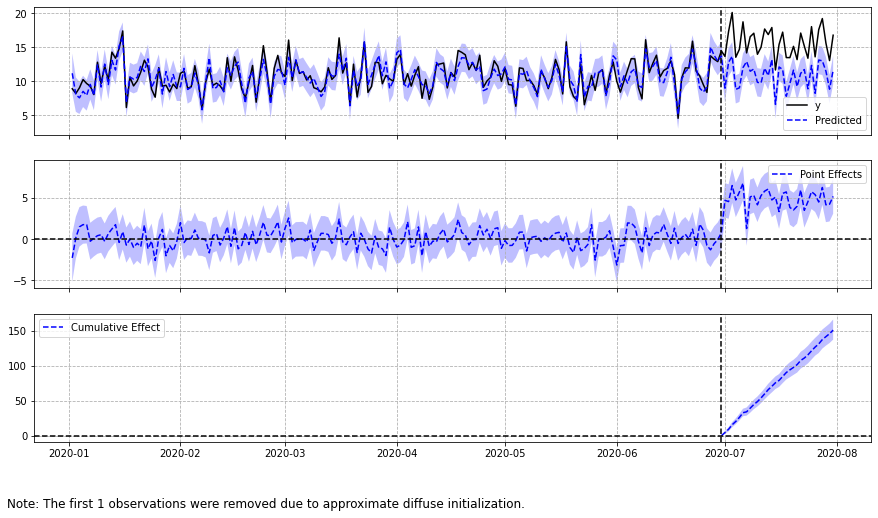

In [12]:
# Set parameters of the model

pre_period = ["2020-01-01","2020-06-30"]
post_period = ["2020-07-01","2020-07-31"]

ciModel = CausalImpact(df, pre_period, post_period)

# Model Results Plot
ciModel.plot(figsize=(15,8));

In [13]:
# Model Results - Simple 
print(ciModel.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    15.69              486.34
Prediction (s.d.)         10.83 (0.24)       335.69 (7.33)
95% CI                    [10.34, 11.27]     [320.56, 349.29]

Absolute effect (s.d.)    4.86 (0.24)        150.65 (7.33)
95% CI                    [4.42, 5.35]       [137.04, 165.78]

Relative effect (s.d.)    44.88% (2.18%)     44.88% (2.18%)
95% CI                    [40.82%, 49.38%]   [40.82%, 49.38%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [14]:
# Summary data
ciModel.summary_data

,average,cumulative
actual,15.688258,486.336007
predicted,10.828665,335.688625
predicted_lower,10.340551,320.557080
predicted_upper,11.267520,349.293107
abs_effect,4.859593,150.647381
abs_effect_lower,4.420739,137.042899
abs_effect_upper,5.347707,165.778927
rel_effect,0.448771,0.448771
rel_effect_lower,0.408244,0.408244
rel_effect_upper,0.493847,0.493847


# Building the Causal Impact Model (2)

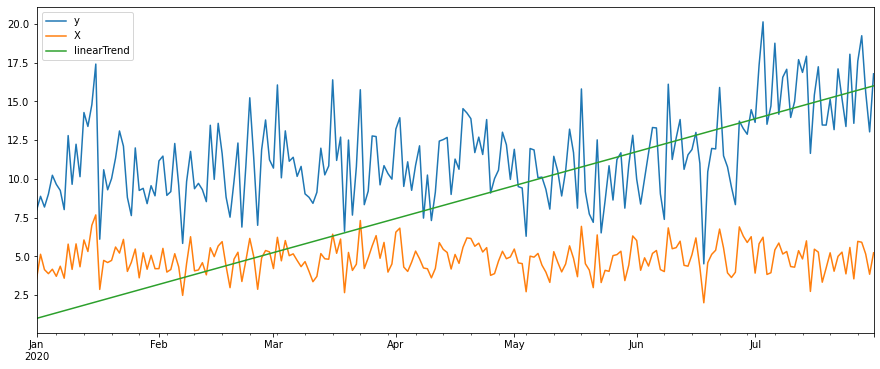

In [15]:
# Adding a linear trend to y:
linear_trend = response_linearfunc(np.linspace(0,5,len(ti)), 3, 1)
df['linearTrend'] = linear_trend
# Re-Plotting the Series
df.plot(figsize=(15,6));

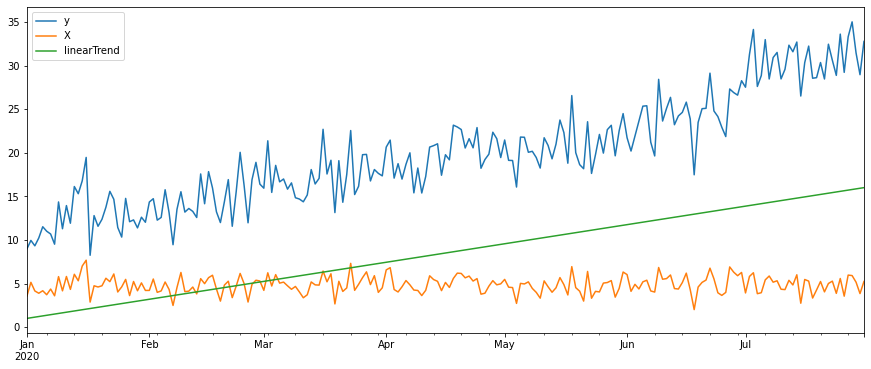

In [16]:
df['y'] = df['y'] + df['linearTrend']
# Re-Plotting the Series
df.plot(figsize=(15,6));

In [17]:
# Adding seasonal trend with synthetic seasonal data:
def simulate_seasonal_term(periodicity, total_cycles, noise_std=1.,
                           harmonics=None):
    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration # Pad for burn in
    series = np.zeros(total_timesteps)
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (gamma_jt[j - 1] * cos_j
                                 + gamma_star_jt[j - 1] * sin_j
                                 + noise_std * np.random.randn())
            gamma_star_jtp1[j - 1] = (- gamma_jt[j - 1] * sin_j
                                      + gamma_star_jt[j - 1] * cos_j
                                      + noise_std * np.random.randn())
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:] # Discard burn in

    return wanted_series

duration = len(ti)
periodicities = [30]
num_harmonics = [1]
std = np.array([0.1, 0.1])

terms = []
for ix, _ in enumerate(periodicities):
    s = simulate_seasonal_term(
        periodicities[ix],
        duration / periodicities[ix],
        harmonics=num_harmonics[ix],
        noise_std=std[ix])
    terms.append(s)
terms.append(np.ones_like(terms[0]) * 10.)
seasons = pd.Series(np.sum(terms, axis=0))

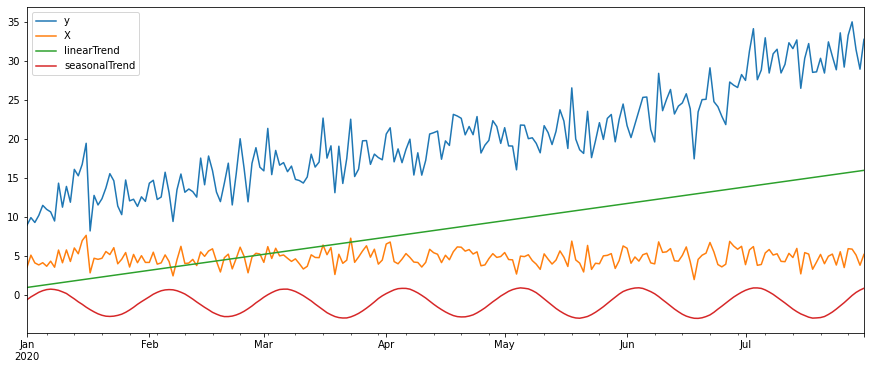

In [18]:
df['seasonalTrend'] = (seasons.values / 5) - 3
# Re-Plotting the Series
df.plot(figsize=(15,6));

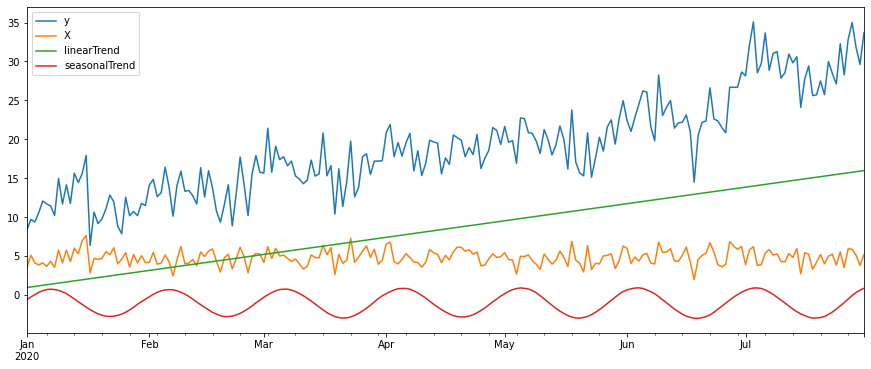

In [19]:
df['y'] = df['y'] + df['seasonalTrend']
# Re-Plotting the Series
df.plot(figsize=(15,6));

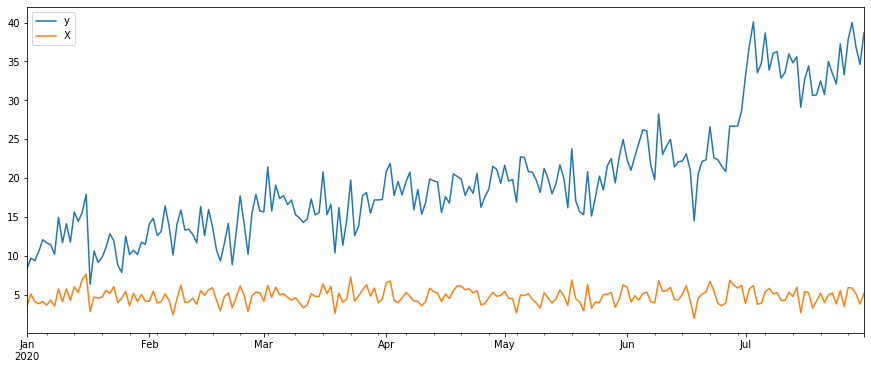

In [20]:
# Introducing Incremental Effect at last 30 days by 5 units
df['y'].loc['2020-07-01':] = df['y'].loc['2020-07-01':] + 5
df.drop(['linearTrend', 'seasonalTrend'], axis=1, inplace=True)
# Checking the Result of Incremental Effect
df.plot(figsize=(15,6));

# Causal Impact Analysis

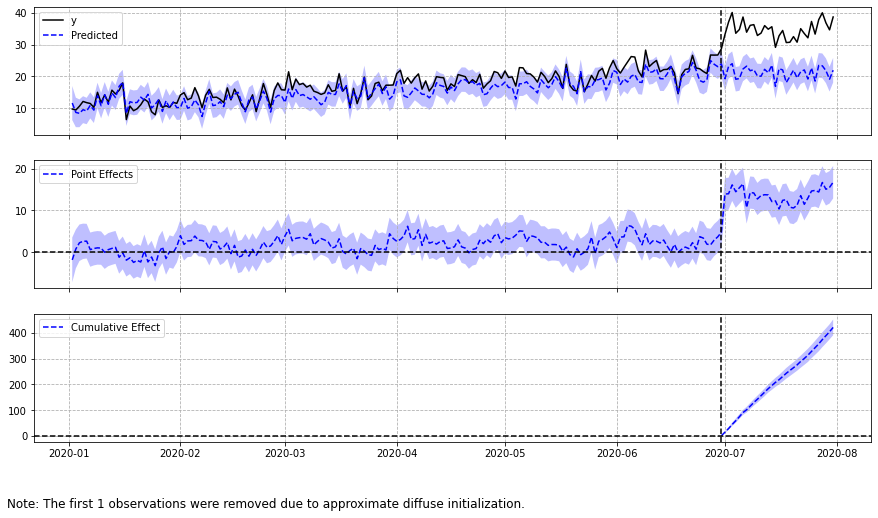

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    34.72              1076.27
Prediction (s.d.)         21.14 (0.51)       655.23 (15.69)
95% CI                    [20.14, 22.12]     [624.31, 685.8]

Absolute effect (s.d.)    13.58 (0.51)       421.04 (15.69)
95% CI                    [12.6, 14.58]      [390.48, 451.97]

Relative effect (s.d.)    64.26% (2.39%)     64.26% (2.39%)
95% CI                    [59.59%, 68.98%]   [59.59%, 68.98%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [21]:
# Setting model parameters:
pre_period = ["2020-01-01","2020-06-30"]
post_period = ["2020-07-01","2020-07-31"]
ciModel = CausalImpact(df, pre_period, post_period)

# Model Results Plot
ciModel.plot(figsize=(15,8));

# Model Results - Simple 
print(ciModel.summary())

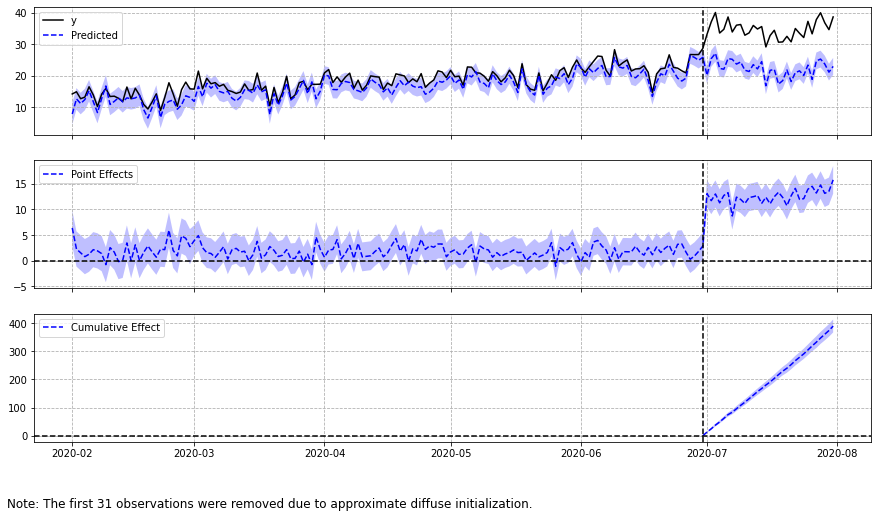

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    34.72              1076.27
Prediction (s.d.)         22.16 (0.38)       686.97 (11.78)
95% CI                    [21.4, 22.89]      [663.45, 709.64]

Absolute effect (s.d.)    12.56 (0.38)       389.31 (11.78)
95% CI                    [11.83, 13.32]     [366.63, 412.82]

Relative effect (s.d.)    56.67% (1.72%)     56.67% (1.72%)
95% CI                    [53.37%, 60.09%]   [53.37%, 60.09%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [22]:
# Passing Periodicity
ciModel = CausalImpact(df, pre_period, post_period, nseasons=[{'period': 30}])

# Model Results Plot
ciModel.plot(figsize=(15,8));

# Model Results - Simple 
print(ciModel.summary())

# Building the Causal Impact Model (3) - Real World Data:

#VolksWagen Polution Emission Scandal Analysis

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab_Notebooks/Projects/GoogleCausalImpact


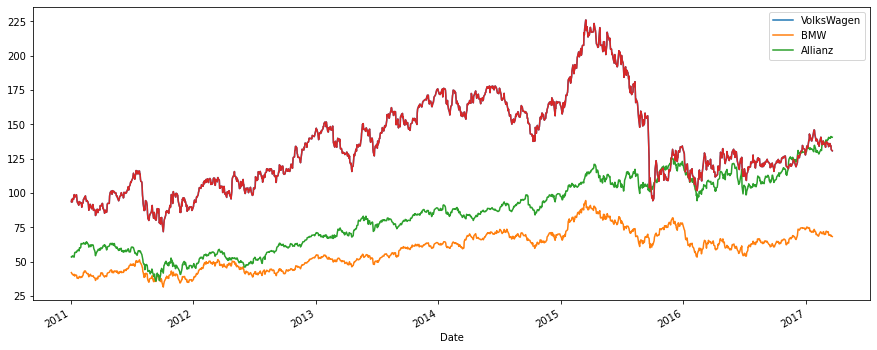

In [31]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Colab_Notebooks/Projects/GoogleCausalImpact'

# Read Data
df = pd.read_csv('volkswagen_scandal_analysis.csv', index_col='Date', parse_dates=['Date'])

# Checking the Result of Incremental Effect
df.plot(figsize=(15,6));

df['VolksWagen'].plot(figsize=(15,6));

# Causal Impact Analysis

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


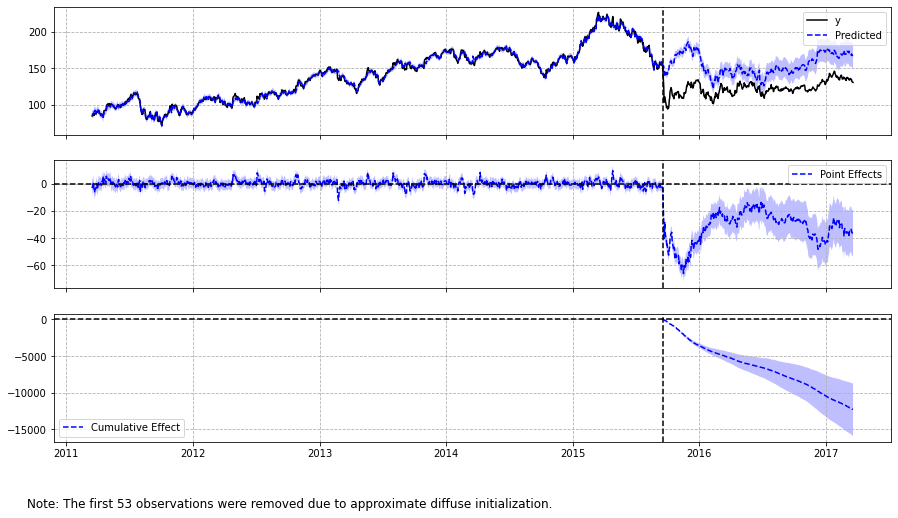

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    122.61             46961.14
Prediction (s.d.)         154.72 (4.77)      59256.93 (1825.86)
95% CI                    [145.46, 164.15]   [55710.59, 62867.82]

Absolute effect (s.d.)    -32.1 (4.77)       -12295.8 (1825.86)
95% CI                    [-41.53, -22.84]   [-15906.68, -8749.45]

Relative effect (s.d.)    -20.75% (3.08%)    -20.75% (3.08%)
95% CI                    [-26.84%, -14.77%] [-26.84%, -14.77%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [32]:
#Setting model parameters
pre_period = [df.index.min(), "2015-09-18"]
post_period = ["2015-09-21", df.index.max()]

ciModel = CausalImpact(df, pre_period, post_period, nseasons=[{'period': 52}])

# Model Results Plot
ciModel.plot(figsize=(15,8));

# Model Results - Simple 
print(ciModel.summary())